In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
housing = pd.read_csv('housing.csv')

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# Let's see if there are any nulls

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# All attributes are numerical - except ocean_proximity

housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
# Let's look at the summary of numerical attributes

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


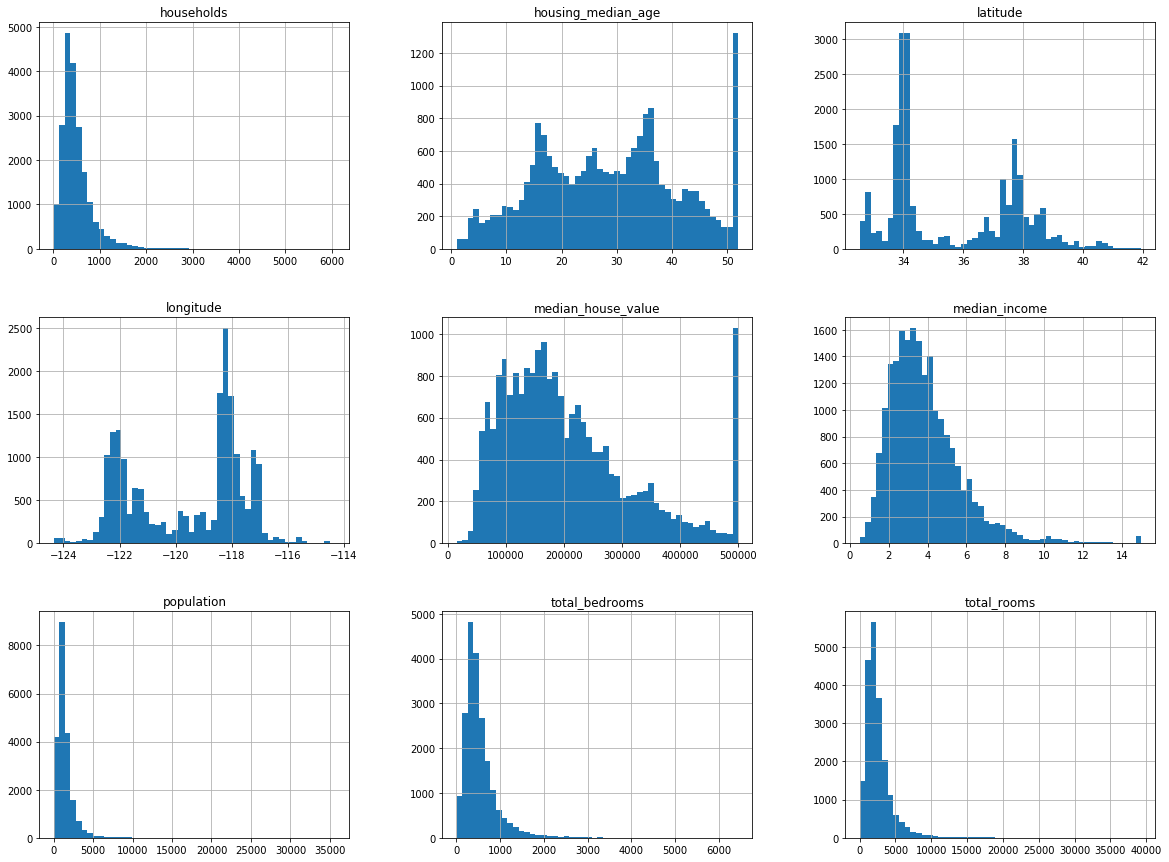

In [6]:
# Histogram of numerical data

housing.hist(bins=50, figsize=(20, 15))
plt.show()

A few things to note from the histograms:

1. The median_income does not seem to be in US dollars. 
    - This data is scaled and capped at 15 for higher median incomes, and 0.5 for lower median incomes. The numbers represent roughly \\$10,000s (so 3 is actually \\$30,000)
    
2. The housing_median_age and median_house_value are also capped.
    - median_house_value being capped may become a serious problem since this is our target attribute. If we need a precise value, then we have 2 options:
        - Collect proper labels for the districts whose labels were capped
        - Remove those districts from our dataset
 
3. All the scales seem to be different.

4. Many of the histograms are tail heavy. We may have to transform these.

Let's assume that the median_income feature is very important to predict median housing prices. 

We will want to ensure that our test set is representative of the various categories of incomes in the whole dataset. Since the median_income is a continuous numerical attribute, we need to create an income category attribute.

In [7]:
# Most median_income values are clustered around 1.5 to 6 ($15k to $60k)

housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5])

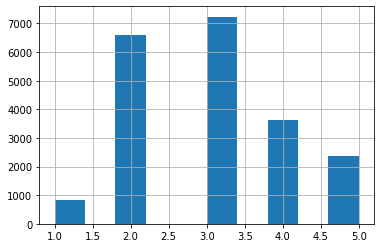

In [8]:
housing['income_cat'].hist()

### Split Data - Train & Test Sets

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#### Stratified Sampling

Stratified Sampling will allow us to divide the data into homogeneous groups that accounts for all bins (so they're not unknown in the train/test sets).

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [11]:
# We can validate our split by looking at the income_cat proportions

print('Train\n{}'.format(strat_train_set['income_cat'].value_counts() / strat_train_set.shape[0]))
print('\nTest\n{}'.format(strat_test_set['income_cat'].value_counts() / strat_test_set.shape[0]))
print('\nOriginal\n{}'.format(housing['income_cat'].value_counts() / housing.shape[0]))

Train
3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

Test
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Original
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


In [12]:
# We can remove our 'income_cat' feature now that our data is properly split

for i in (strat_train_set, strat_test_set):
    i.drop('income_cat', axis=1, inplace=True)

### Visualizing Our Data

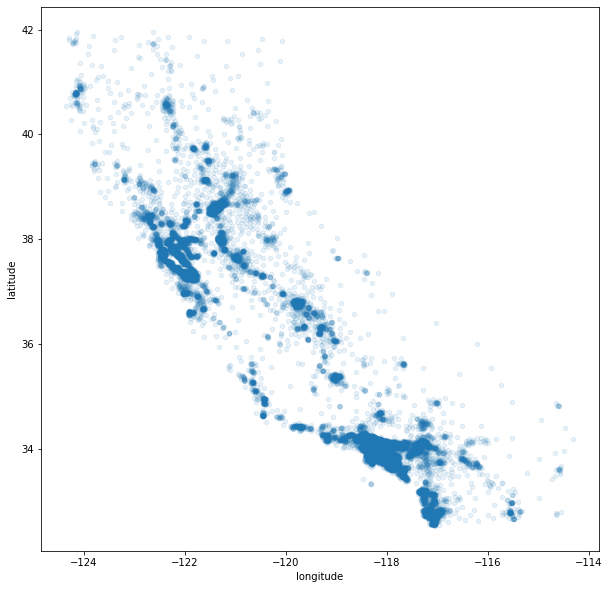

In [13]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, figsize=(10,10))

From the figure above, we can now see the density of housing distribution. Denser areas have overlaps in the scatter.

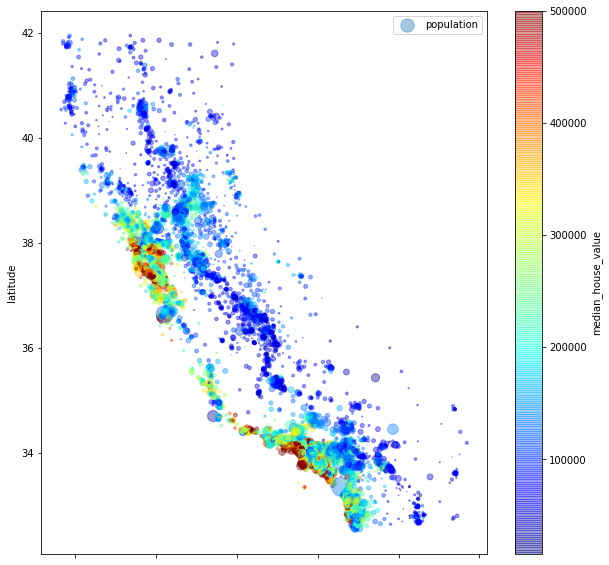

In [14]:
# Circle Radius will now be proportional to 'population'
# Circle Color represents the house value

housing.plot(kind='scatter', x='longitude', y='latitude', s=housing['population']/100, label='population',
             c='median_house_value', cmap=plt.get_cmap('jet'), alpha=0.4, figsize=(10,10))

The above figure now shows us the housing market while highlighting population and median house value based on scatter sizes.

As we can see, there is a clear relation between being close to the water and house value. The northern coast however does not represent this assumption.

### Pearson's Correlation

In [15]:
corr_matrix = housing.corr()

In [16]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

A correlation of 1 -> strong positive correlation
- From above we see that the median house value tends to go up when the median income goes up.

A correlation of -1 -> strong negative correlation
- We can see a small negative correlation between latitude and median house value (prices decrease when moving north)

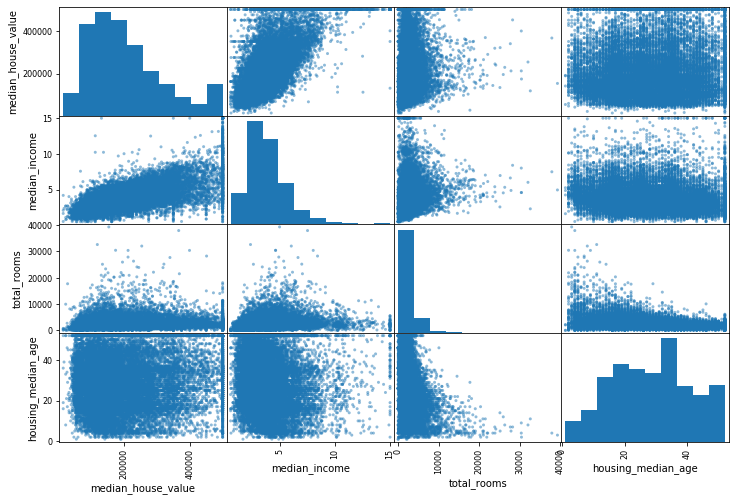

In [17]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

Median_income seems very promising towards predicting median_house_value.

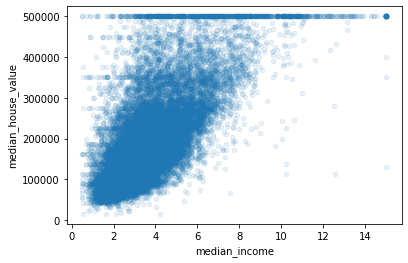

In [18]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

In [19]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


### Attribute Combinations (Feature Engineering)

In [20]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"]=housing["population"] / housing["households"]

In [21]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

Looks like 'bedrooms_per_room' has a negative correlation with median_house_value. So as house prices go up, there are less bedrooms.

## Data Preparation

In [22]:
# Separate predictors from labels

housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

In [ ]:
# [total_bedrooms] has some null values, our options are:

# Get rid of the corresponding districts with these nulls
# housing['total_bedrooms'].dropna(axis=0, inplace=True)

# Get rid of the whole attribute
# housing.drop('total_bedrooms', axis=1, inplace=True)

# Set the values to some value (zero, mean, median, etc.)
# median = housing['total_bedrooms'].median()
# housing['total_bedrooms'].fillna(medium, inplace=True)

If we replace missing data with the median, we will need to compute the median value on the training set and use it to fill the missing values on the training set. Later on, we will use the same median value for the test set.

In [23]:
# SimpleImputer

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# median can only be computed on numerical data
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

print("Medians of numerical labels: {}".format(imputer.statistics_))

# Replace missing values with their medians
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

Medians of numerical labels: [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


### Categorical Attributes

In [24]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [25]:
# Let's convert these to numerical types
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.]])

We have now created a new problem by doing this - we have introducted numerical bias into 'ocean_proximity'.

A value of 4 is greater than 1, so perhaps item 4 will have more weight than 1. To fix this, we will OneHotEncode.

Note that this would have been OK had the values we were encoding been 'good', 'bad', 'average' since their numerical values correspond to their rankings as well.

In [60]:
# Categorical Columns

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# Creates a SciPy sparse matrix (instead of NumPy array) which saves memory.
print(housing_cat['ocean_proximity'].unique())
print(housing_cat_1hot.toarray()[:3])

['<1H OCEAN' 'NEAR OCEAN' 'INLAND' 'NEAR BAY' 'ISLAND']
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


Create a transformer class with only one hyperparameter (add_bedrooms_per_room). This hyperparameter will allow us to easily find out whether adding this attribute helps the ML algorithm or not.

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__ (self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling



### Transformation Pipelines

Pipeline constructor takes a list of names/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e, they must have a fit_transform() method).

In [28]:
# Numerical Columns Transformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [29]:
# Categorical & Numerical Columns Transformer

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

### Train Model

##### Linear Regression

In [67]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
# Let's test out some data on our model

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('Predictions: ', lin_reg.predict(some_data_prepared))
print('Labels: ', list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Our predictions are way off!

In [75]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('RMSE: {:.3f}'.format(lin_rmse))

RMSE: 68628.198


This is a poor score. Most 'median_housing_values' are between \\$120,000 and \\$265,000. So a typical prediction error of $68,628 is not very satisfying.

This is a case of our model underfitting the training data. Our features do not provide enough information to make good predictions, or the model is not powerful enough.

##### Decision Tree Regressor

In [77]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('RMSE: {:.3f}'.format(tree_rmse))

RMSE: 0.000


We have used our test set to predict on and thus our model has overfit the data. Time to use cross validation!

#### Cross Validation

In [86]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: {:.3f}'.format(scores.mean()))
    print('Standard Deviation: {:.3f}'.format(scores.std()))
    
display_scores(tree_rmse_scores)

This is also a poor score. We have a typical prediction error of ~\\$71,000 +/- ~\\$2400.

In [ ]:
# Let's cross-validate the Linear Regression model:

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

We have a typical prediction error of ~\\$69,000 +/- ~\\$2700.

Our Decision Tree is overfitting.

##### Random Forest Regressor

In [87]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print('RMSE: {:.3f}'.format(forest_rmse))

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Our prediction error is much lower now.

The training set is still overfitting - producting an error of ~\\$19,000.
<br> 
The CV set produces an error of ~\\$50,000.

##### Support Vector Machines

#### Grid Search

In [88]:
from sklearn.model_selection import GridSearchCV

# Random Forest GridSearch
param_grid = [
    {'n_estimators' : [3,10,30], 'max_features' : [2,4,6,8]}, 
    {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features' : [2,3,4]}
]


forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

In [ ]:
# Best Parameter Combinations
grid_search.best_params_

In [ ]:
# Best Estimator
grid_search.best_estimator_

In [ ]:
# Evaluation score
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

The best score is obtained when max_features = 8 and n_estimators = 30

#### Feature Importance

We can see what features play the biggest role in our models decision:

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

From here, we can drop some of the less useful features (maybe specific ocean_proximity categories).

### Evaluating on Test Set

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print('RMSE: {:.3f}'.format(final_rmse))

Our error is about ~\\$48,000 - still better than all previous models.

If we want to see how precise the estimate is, we can compute a 95% *confidence interval* for the generalization error:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))